## Testing CODE

In [51]:
import pandas as pd

# Load the CSV file
file_path = 'China_edited_data.csv'  # Adjust with your actual file path
real_data = pd.read_csv(file_path)

# Display the first few rows to inspect the structure
real_data

,Province/State,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,Observation Date
0,Anhui,Mainland China,1,0,0,32.0,117.0,22-01-2020
1,Anhui,Mainland China,9,0,0,32.0,117.0,23-01-2020
2,Anhui,Mainland China,15,0,0,32.0,117.0,24-01-2020
3,Anhui,Mainland China,39,0,0,32.0,117.0,25-01-2020
4,Anhui,Mainland China,60,0,0,32.0,117.0,26-01-2020
...,...,...,...,...,...,...,...,...
1661,Zhejiang,Mainland China,1215,1,1195,29.0,120.0,11-03-2020
1662,Zhejiang,Mainland China,1215,1,1197,29.0,120.0,12-03-2020
1663,Zhejiang,Mainland China,1215,1,1197,29.0,120.0,13-03-2020
1664,Zhejiang,Mainland China,1227,1,1211,29.0,120.0,14-03-2020


In [52]:
# Extract the relevant columns (adjust column names based on the dataset)
infected_data = real_data['Confirmed'] - real_data['Recovered'] - real_data['Deaths']   # Replace with the actual column name for confirmed cases
recovered_data = real_data['Recovered']  # Replace with the actual column name for recovered cases
deaths_data = real_data['Deaths']  # Replace with the actual column name for deaths

# Display the extracted data to confirm
infected_data

0        1
1        9
2       15
3       39
4       60
        ..
1661    19
1662    17
1663    17
1664    15
1665    19
Length: 1666, dtype: int64

In [53]:
# Assuming a total population N
N = 1_000_000  # Adjust according to your dataset

# Estimate Susceptible (S) compartment
susceptible_data = N - real_data['Confirmed'] - recovered_data - deaths_data

# Assuming a percentage of asymptomatic cases (you can modify this assumption)
percentage_asymptomatic = 0.3  # Assuming 10% of confirmed cases are asymptomatic
asymptomatic_data = percentage_asymptomatic * infected_data

# Display the estimated Susceptible (S) and Asymptomatic (A) data
susceptible_data
asymptomatic_data


0        0.3
1        2.7
2        4.5
3       11.7
4       18.0
        ... 
1661     5.7
1662     5.1
1663     5.1
1664     4.5
1665     5.7
Length: 1666, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_3572\1653458254.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  susceptible_data = torch.tensor(susceptible_data, dtype=torch.float32).reshape(-1, 1)
C:\Users\user\AppData\Local\Temp\ipykernel_3572\1653458254.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  asymptomatic_data = torch.tensor(asymptomatic_data, dtype=torch.float32).reshape(-1, 1)
C:\Users\user\AppData\Local\Temp\ipykernel_3572\1653458254.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recovered_data = torch.tensor(reco

Epoch 0, Loss: 995179888640.0, Alpha: 0.10099998861551285, Beta: 0.16900001466274261, Gamma: 0.061500001698732376, Delta: 1.6298145055770874e-09
Epoch 500, Loss: 995103801344.0, Alpha: 0.028756840154528618, Beta: 0.22258438169956207, Gamma: 0.00015596809680573642, Delta: 0.0001302259333897382


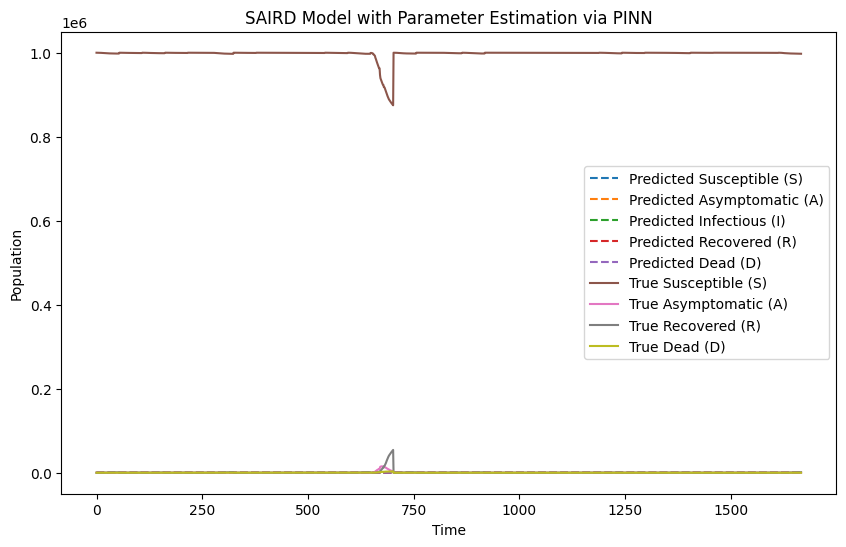

In [46]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Extract the relevant columns for Susceptible (S), Asymptomatic (A), Recovered (R), and Deaths (D)
# susceptible_data = real_data['Susceptible'].values  # Replace with actual column name
# asymptomatic_data = real_data['Asymptomatic'].values  # Replace with actual column name
# recovered_data = real_data['Recovered'].values
# deaths_data = real_data['Deaths'].values

# Total population (adjust as needed)
N = 1_000_000  # Or use the actual total population value if known

# Create time points
t_train = torch.linspace(0, len(susceptible_data), len(susceptible_data)).reshape(-1, 1)
t_train.requires_grad = True

# Convert data to tensors
susceptible_data = torch.tensor(susceptible_data, dtype=torch.float32).reshape(-1, 1)
asymptomatic_data = torch.tensor(asymptomatic_data, dtype=torch.float32).reshape(-1, 1)
recovered_data = torch.tensor(recovered_data, dtype=torch.float32).reshape(-1, 1)
deaths_data = torch.tensor(deaths_data, dtype=torch.float32).reshape(-1, 1)

# Neural network model for estimating SAIRD compartments and parameters
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 5)
        self.activation = torch.tanh

        # Initialize the parameters to be learned
        self.alpha = torch.nn.Parameter(torch.tensor(0.1))
        self.beta = torch.nn.Parameter(torch.tensor(0.17))
        self.gamma = torch.nn.Parameter(torch.tensor(1/16))
        self.delta = torch.nn.Parameter(torch.tensor(0.001))
        self.rho_1 = torch.nn.Parameter(torch.tensor(0.80))
        self.rho_2 = torch.nn.Parameter(torch.tensor(0.29))

    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        output = self.fc3(x)
        return output

# SAIRD model residuals based on the learned parameters
def saird_residuals(model, t):
    SIRD = model(t)
    S, A, I, R, D = SIRD[:, 0], SIRD[:, 1], SIRD[:, 2], SIRD[:, 3], SIRD[:, 4]

    # Derivatives using autograd
    S_t = autograd.grad(S.sum(), t, create_graph=True)[0]
    A_t = autograd.grad(A.sum(), t, create_graph=True)[0]
    I_t = autograd.grad(I.sum(), t, create_graph=True)[0]
    R_t = autograd.grad(R.sum(), t, create_graph=True)[0]
    D_t = autograd.grad(D.sum(), t, create_graph=True)[0]

    # SAIRD equations
    f1 = S_t + model.alpha * A * S + model.beta * I * S 
    f2 = A_t - (1 - model.rho_1) * model.alpha * A * S - model.rho_2 * model.beta * I * S  + model.gamma * A + model.delta * A
    f3 = I_t - (1 - model.rho_2) * model.beta * I * S  - model.rho_1 * model.alpha * A * S  + model.gamma * I + model.delta * I
    f4 = R_t - model.gamma * A - model.gamma * I
    f5 = D_t - model.delta * A - model.delta * I

    return f1, f2, f3, f4, f5

# Loss function combining both data loss and residual loss
def loss_function(model, t, susceptible, asymptomatic, recovered, deaths):
    # Predict Susceptible (S), Asymptomatic (A), Infectious (I), Recovered (R), Dead (D)
    S_pred, A_pred, I_pred, R_pred, D_pred = model(t).T

    # Data loss (mean squared error)
    data_loss = torch.mean((S_pred - susceptible) ** 2) + torch.mean((A_pred - asymptomatic) ** 2) + \
                torch.mean((R_pred - recovered) ** 2) + torch.mean((D_pred - deaths) ** 2)

    # Residual loss from SAIRD ODEs
    f1, f2, f3, f4, f5 = saird_residuals(model, t)
    residual_loss = torch.mean(f1**2) + torch.mean(f2**2) + torch.mean(f3**2) + torch.mean(f4**2) + torch.mean(f5**2)

    return data_loss + residual_loss

# Training the PINN
def train_pinn(model, optimizer, t_train, susceptible, asymptomatic, recovered, deaths, num_epochs=5000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, t_train, susceptible, asymptomatic, recovered, deaths)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Alpha: {model.alpha.item()}, Beta: {model.beta.item()}, Gamma: {model.gamma.item()}, Delta: {model.delta.item()}")

# Initialize the model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_pinn(model, optimizer, t_train, susceptible_data, asymptomatic_data, recovered_data, deaths_data, num_epochs=1000)

# Plot the results
with torch.no_grad():
    predictions = model(t_train)

plt.figure(figsize=(10, 6))
plt.plot(t_train.detach().numpy(), predictions[:, 0].detach().numpy(), label='Predicted Susceptible (S)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 1].detach().numpy(), label='Predicted Asymptomatic (A)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 2].detach().numpy(), label='Predicted Infectious (I)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 3].detach().numpy(), label='Predicted Recovered (R)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 4].detach().numpy(), label='Predicted Dead (D)', linestyle='--')

plt.plot(t_train.detach().numpy(), susceptible_data.detach().numpy(), label='True Susceptible (S)')
plt.plot(t_train.detach().numpy(), asymptomatic_data.detach().numpy(), label='True Asymptomatic (A)')
plt.plot(t_train.detach().numpy(), recovered_data.detach().numpy(), label='True Recovered (R)')
plt.plot(t_train.detach().numpy(), deaths_data.detach().numpy(), label='True Dead (D)')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SAIRD Model with Parameter Estimation via PINN')
plt.legend()
plt.show()


Epoch 0, Loss: 853332.875
Epoch 100, Loss: 832903.9375
Epoch 200, Loss: 820118.75
Epoch 300, Loss: 807971.875
Epoch 400, Loss: 796140.8125


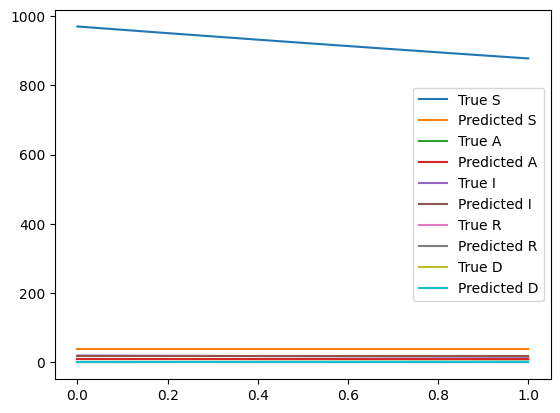

In [48]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Define the SAIRD model parameters
class SAIRD_PINN(nn.Module):
    def __init__(self):
        super(SAIRD_PINN, self).__init__()
        # Neural network with 4 hidden layers, 64 neurons each
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)  # Output: S, A, I, R, D
        )
        # Initial guess for the model parameters (learned during training)
        self.beta1 = torch.tensor(0.25, requires_grad=True)
        self.beta2 = torch.tensor(0.15, requires_grad=True)
        self.gamma1 = torch.tensor(0.05, requires_grad=True)
        self.gamma2 = torch.tensor(0.03, requires_grad=True)
        self.gamma3 = torch.tensor(0.01, requires_grad=True)
        self.kappa1 = torch.tensor(0.01, requires_grad=True)
        self.kappa2 = torch.tensor(0.01, requires_grad=True)
        self.mu = torch.tensor(0.0001, requires_grad=True)
        self.Lambda = torch.tensor(0.0001, requires_grad=True)

    def forward(self, t):
        # Forward pass to get the predicted values
        S, A, I, R, D = torch.split(self.network(t), 1, dim=1)
        return S, A, I, R, D

# Derivatives for the loss function
def derivatives(y, t):
    return grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

# Loss function combining data and residual loss
def loss_fn(model, t, data, N):
    S, A, I, R, D = model(t)
    
    # ODE residuals
    dS_dt = derivatives(S, t)
    dA_dt = derivatives(A, t)
    dI_dt = derivatives(I, t)
    dR_dt = derivatives(R, t)
    dD_dt = derivatives(D, t)

    # Loss terms from SAIRD ODEs
    residual_loss = (
        dS_dt - model.Lambda + model.beta1 * S * A + model.beta2 * S * I + model.mu * S
        + dA_dt - model.beta1 * S * A + (model.gamma1 + model.gamma2 + model.gamma3) * A + model.mu * A
        + dI_dt - model.beta2 * S * I - model.gamma1 * A + (model.kappa1 + model.kappa2) * I + model.mu * I
        + dR_dt - model.gamma2 * A - model.kappa1 * I + model.mu * R
        + dD_dt - model.gamma3 * A - model.kappa2 * I
    )
    
    # Data loss
    data_loss = torch.mean((S - data[:, 0]) ** 2 + (A - data[:, 1]) ** 2 + (I - data[:, 2]) ** 2 +
                           (R - data[:, 3]) ** 2 + (D - data[:, 4]) ** 2)

    # Total loss
    return data_loss + torch.mean(residual_loss ** 2)

# Training loop
def train(model, t, data, epochs, N, optimizer):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t, data, N)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generating synthetic data (for validation) or loading real data
def generate_synthetic_data():
    t = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)  # Time points
    S = 970 * torch.exp(-0.1 * t)
    A = 10 * torch.exp(-0.1 * t)
    I = 20 * torch.exp(-0.2 * t)
    R = 0 * torch.exp(0.05 * t)
    D = 0 * torch.exp(0.01 * t)
    data = torch.cat([S, A, I, R, D], dim=1)
    return t, data

# Main execution
if __name__ == "__main__":
    # Generate synthetic data (or replace with actual COVID data for China)
    t, data = generate_synthetic_data()
    
    # Initialize the model and optimizer
    model = SAIRD_PINN()
    optimizer = torch.optim.Adam([
        {'params': model.network.parameters()},
        {'params': [model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda]}
    ], lr=1e-3)
    
    # Train the model
    N = 1000  # Total population
    train(model, t, data, epochs=500, N=N, optimizer=optimizer)
    
    # Plot results (predicted vs. true)
    with torch.no_grad():
        S_pred, A_pred, I_pred, R_pred, D_pred = model(t)
        
        plt.plot(t, data[:, 0], label="True S")
        plt.plot(t, S_pred, label="Predicted S")
        
        plt.plot(t, data[:, 1], label="True A")
        plt.plot(t, A_pred, label="Predicted A")
        
        plt.plot(t, data[:, 2], label="True I")
        plt.plot(t, I_pred, label="Predicted I")
        
        plt.plot(t, data[:, 3], label="True R")
        plt.plot(t, R_pred, label="Predicted R")
        
        plt.plot(t, data[:, 4], label="True D")
        plt.plot(t, D_pred, label="Predicted D")
        
        plt.legend()
        plt.show()


Epoch 0, Loss: 995208200192.0
Epoch 100, Loss: 995185983488.0
Epoch 200, Loss: 995172155392.0
Epoch 300, Loss: 995158654976.0
Epoch 400, Loss: 995145416704.0
Epoch 500, Loss: 995132243968.0
Epoch 600, Loss: 995119071232.0
Epoch 700, Loss: 995105767424.0
Epoch 800, Loss: 995092791296.0
Epoch 900, Loss: 995079749632.0


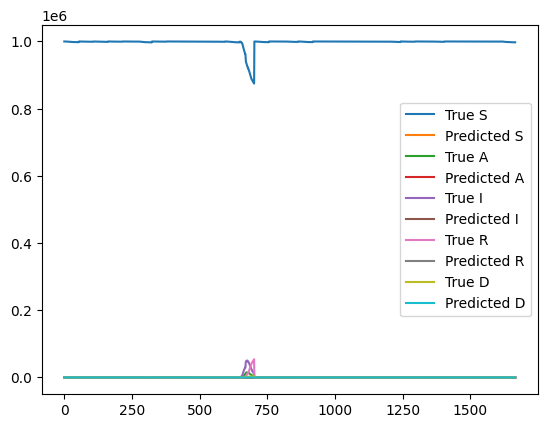

In [54]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load real data from CSV
def load_real_data(file_path):
    # data = pd.read_csv(file_path)
    # Ensure columns match ['Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Dead']
    # You can adjust the column names depending on your dataset.
    t = torch.tensor(infected_data.index.values, dtype=torch.float32, requires_grad=True).reshape(-1, 1)  # Time (in days)
    
    # Normalize data based on population size (replace 1000 with actual population size)
    N = 1_000_000  # Replace with actual population size
    # S = torch.tensor(data['Susceptible'].values, dtype=torch.float32).reshape(-1, 1) / N
    # A = torch.tensor(data['Asymptomatic'].values, dtype=torch.float32).reshape(-1, 1) / N
    # I = torch.tensor(data['Infected'].values, dtype=torch.float32).reshape(-1, 1) / N
    # R = torch.tensor(data['Recovered'].values, dtype=torch.float32).reshape(-1, 1) / N
    # D = torch.tensor(data['Dead'].values, dtype=torch.float32).reshape(-1, 1) / N

    S = torch.tensor(susceptible_data.values, dtype=torch.float32).reshape(-1, 1)
    A = torch.tensor(asymptomatic_data.values, dtype=torch.float32).reshape(-1, 1)
    I = torch.tensor(infected_data.values, dtype=torch.float32).reshape(-1, 1)
    R = torch.tensor(recovered_data.values, dtype=torch.float32).reshape(-1, 1)
    D = torch.tensor(deaths_data.values, dtype=torch.float32).reshape(-1, 1)
    
    # Combine data into one tensor
    real_data = torch.cat([S, A, I, R, D], dim=1)
    
    return t, real_data, N

# Main execution for real data
if __name__ == "__main__":
    # Replace 'china_covid_data.csv' with the actual path to your dataset
    file_path = 'china_covid_data.csv'
    t, data, N = load_real_data(file_path)
    
    # Initialize the model and optimizer
    model = SAIRD_PINN()
    optimizer = torch.optim.Adam([
        {'params': model.network.parameters()},
        {'params': [model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda]}
    ], lr=1e-3)
    
    # Train the model on real data
    train(model, t, data, epochs=1000, N=N, optimizer=optimizer)
    
    # Plot results (predicted vs. true)
    with torch.no_grad():
        S_pred, A_pred, I_pred, R_pred, D_pred = model(t)
        
        plt.plot(t, data[:, 0], label="True S")
        plt.plot(t, S_pred, label="Predicted S")
        
        plt.plot(t, data[:, 1], label="True A")
        plt.plot(t, A_pred, label="Predicted A")
        
        plt.plot(t, data[:, 2], label="True I")
        plt.plot(t, I_pred, label="Predicted I")
        
        plt.plot(t, data[:, 3], label="True R")
        plt.plot(t, R_pred, label="Predicted R")
        
        plt.plot(t, data[:, 4], label="True D")
        plt.plot(t, D_pred, label="Predicted D")
        
        plt.legend()
        plt.show()


In [55]:
model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda

(tensor(0.2500, requires_grad=True),
 tensor(0.1500, requires_grad=True),
 tensor(0.0500, requires_grad=True),
 tensor(0.0300, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(0.0004, requires_grad=True),
 tensor(0.1218, requires_grad=True))

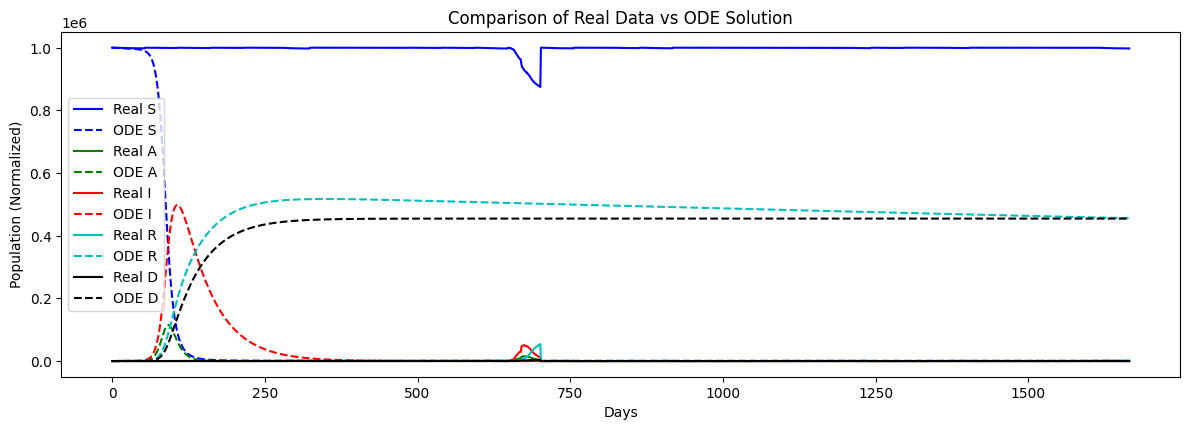

In [56]:
import pandas as pd
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the SAIRD ODE system
def saird_ode(y, t, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda, N):
    S, A, I, R, D = y
    dS_dt = Lambda - beta1 * S * A / N - beta2 * S * I / N - mu * S
    dA_dt = beta1 * S * A / N - (gamma1 + gamma2 + gamma3) * A - mu * A
    dI_dt = beta2 * S * I / N + gamma1 * A - (kappa1 + kappa2) * I - mu * I
    dR_dt = gamma2 * A + kappa1 * I - mu * R
    dD_dt = gamma3 * A + kappa2 * I
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Solve the SAIRD ODE using learned parameters
def solve_saird_with_odeint(t, model, N, y0):
    # Extract learned parameters from the trained model
    beta1 = model.beta1.item()
    beta2 = model.beta2.item()
    gamma1 = model.gamma1.item()
    gamma2 = model.gamma2.item()
    gamma3 = model.gamma3.item()
    kappa1 = model.kappa1.item()
    kappa2 = model.kappa2.item()
    mu = model.mu.item()
    Lambda = model.Lambda.item()

    # Use odeint to solve the ODE
    solution = odeint(saird_ode, y0, t, args=(beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda, N))

    return solution

# Load real data from CSV (replace with your actual file path)
def load_real_data(file_path):
    # data = pd.read_csv(file_path)
    
    # Ensure columns match ['Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Dead']
    t = np.arange(len(data))  # Time in days (assuming one entry per day)
    
    # Normalize data based on population size (replace 1000 with actual population size)
    N = 1_000_000  # Replace with actual population size

    # S = torch.tensor(susceptible_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # A = torch.tensor(asymptomatic_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # I = torch.tensor(infected_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # R = torch.tensor(recovered_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # D = torch.tensor(deaths_data.values, dtype=torch.float32).reshape(-1, 1) / N
    
    # S = data['Susceptible'].values / N
    # A = data['Asymptomatic'].values / N
    # I = data['Infected'].values / N
    # R = data['Recovered'].values / N
    # D = data['Dead'].values / N

    S = susceptible_data.values / N
    A = asymptomatic_data.values / N
    I = infected_data.values / N
    R = recovered_data.values / N
    D = deaths_data.values / N
    
    # Combine data into one array
    real_data = np.stack([S, A, I, R, D], axis=1)
    
    return t, real_data, N

# Main execution for solving the ODE system using real data
if __name__ == "__main__":
    # Replace 'china_covid_data.csv' with the actual path to your dataset
    file_path = 'china_covid_data.csv'
    t_real, real_data, N = load_real_data(file_path)
    
    # Initial conditions from the first row of the real data
    S0 = real_data[0, 0] * N
    A0 = real_data[0, 1] * N
    I0 = real_data[0, 2] * N
    R0 = real_data[0, 3] * N
    D0 = real_data[0, 4] * N
    y0 = [S0, A0, I0, R0, D0]  # Initial state

    # Initialize the trained model (replace with your actual trained model)
    model = SAIRD_PINN()  # Assume the model has already been trained
    # You should replace the above line with your trained model instance

    # Solve the ODE using the learned parameters
    solution = solve_saird_with_odeint(t_real, model, N, y0)
    S_ode, A_ode, I_ode, R_ode, D_ode = solution.T  # Transpose the solution

    # Plot the ODE solution vs real data
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_real, real_data[:, 0]*N, 'b-', label="Real S")
    plt.plot(t_real, S_ode, 'b--', label="ODE S")
    
    plt.plot(t_real, real_data[:, 1]*N, 'g-', label="Real A")
    plt.plot(t_real, A_ode, 'g--', label="ODE A")
    
    plt.plot(t_real, real_data[:, 2]*N, 'r-', label="Real I")
    plt.plot(t_real, I_ode, 'r--', label="ODE I")
    
    plt.plot(t_real, real_data[:, 3]*N, 'c-', label="Real R")
    plt.plot(t_real, R_ode, 'c--', label="ODE R")
    
    plt.plot(t_real, real_data[:, 4]*N, 'k-', label="Real D")
    plt.plot(t_real, D_ode, 'k--', label="ODE D")
    
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Population (Normalized)')
    plt.title('Comparison of Real Data vs ODE Solution')
    
    # Show both plots
    plt.tight_layout()
    plt.show()
